In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from astropy.io import ascii

In [2]:
def F_nu(t_p,nu_p,F_nup,nu_sed):
    '''Calculates a Synchrotron Self-Absorbed Spectrum for given input parameters.
    
    Parameters:
    t_p (days): Time of SSA peak - should be single number
    nu_p (GHz): Frequency of SSA peak - should be single number
    F_nup (mJy): Flux of SSA peak - should be single number
    nu (GHz): Frequencies at which you want the SSA spectrum to be calculated at. Likely an array.
    
    Outputs:
    Fnu (mJy): the flux of the SSA. This is an array with values associated with each value of input array nu.
    '''
    
    m = 0.88 #using stAandard model
    p = 3.0 #using standard model
    a = (2*m)+0.5
    b = (p+5-(6*m))/2
    t=t_p
    Fnu = F_nup*1.582*(t/t_p)**a*(nu_sed/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu_sed/nu_p)**(-(p+4)/2)))
    
    return Fnu


def SSA_props(t_p,nu_p,F_nup,D_L,f=0.5,alpha=1,vw=100,epsilon_b=0.1):
    '''Calculates Synchroton Self-Absorption properties for given input parameters.
    
    Inputs:
    t_p (days): Time of SSA peak - likely a single number
    nu_p (GHz): Frequency of SSA peak - likely a single number
    F_nup (mJy): Flux of SSA peak - likely a single number
    D (Mpc): angular distance to SN - likely a single number while D_L is the luminosity distance
    f (unitless): filling factor (fraction of emitting region). default is 0.5
    alpha (unitless): ratio charged particles to magnetic field (epsilon_e/epsilon_b). default 1
    v_w (km/s): wind speed. default = 100
    epsilon_b (unitless): fraction of shock energy into B-fields. default = 0.1
    
    Outputs:
    R (cm): radius of material 
    B : magnetic field flux
    E : intermal energy of emitting material
    v (km/s): expansion velocity of material
    M (1d-5 solar masses per year): inferred mass loss rate of progenitor'''
    
    #angular distance
    D = D_L/((1+z)**2)
    
    #Radius
    R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

    # Magnetic field flux
    B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

    #Internal energy of the emitting material
    E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

    #expansion velocity in km/s
    v = (R/t_p)*1.1574e-10

    #pre-explosion mass-loss in 1e-5 solar mass per year
    M = 1.0*(alpha)**(-8/19)*(epsilon_b/0.1)*(f/0.5)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(vw/1000)
    
   

    return R,B,E,v,M


def taufreefree(M,R,nu):
    '''Calculates the free free optical depth for a given set of parameters.
    
    Inputs:
    M (1d-5 solar masses per year): mass loss rate
    R (cm): radius of emitting material
    nu (GHz): Frequencies at which you want tau-ff to be calculated at. Likely an array.
    
    Outputs:
    tau_ff (unitless): the free-free optical depth, calculated at same frequences as input array nu'''

    Z_ave = 5.4  # Average metallicity 1= pure H. 5.4 for a massive star
    miu = 1.9 # mean molecular weight of electrons. 1= pure H  1.9 is for a massive star.
    vw_cgs = 100 * 1e5 # assumed wind velocity in cgs (cm/s). Take this as 1000 * 10^5 for now. (i.e. 1000 km/s in cgs)
    T = 10**4 # temperature of the material absorbing in K.  10^4 is a good starting point. 
        
    M_cgs =  M * 1e-5 * 6.307e+25 #mass loss rate in cgs units
    
    tau_ff = 2.021e25*M_cgs**2*Z_ave/(miu**2*nu**(2.1)*R**3*vw_cgs**2*T**(1.35))  
    
    return tau_ff

def den(M,R):
    vw_cgs = 100 * 1e5
    M_cgs =  M * 1e-5 * 6.307e+25 #mass loss rate in cgs units 
        #density of the CSM
    density = M_cgs/(4*3.142*R**2*vw_cgs)
    
    return density
#freqs,SED = F_nu(1224.288326 , 8,  0.0272)       
#R2,B2,E2,v2,M2 = SSA_props(1224.288326 , 8,  0.0272,880) 
#tauff=taufreefree(M2,R2,freqs)
#tauff=taufreefree(4,3e14,np.array([2,5,7]))
#print(freqs)
#print(tauff)
#print(R2,B2,E2,v2,M2)

In [5]:
### Define parameters that are specific to the supernova you want to model:###
date_expl = 55770.562 - 5 #55736.161 #inferred explosion date
date_obs = 57829.76513 # date that radio obs was taken
redshift = 0.218 # redshift of object
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#
D_L = 1070.1 # distance to SN in Mpc
z = 0.218
F_ul = [0.405,0.0258] 
F_det = [0.0318,0.0155]
F_det_err = [0.0095,0.0056]
nu_det = [6.05,14.75] #0.0404 #0.0404 # flux of upper limit in mJy
nu_ul = [3.00,9.02] # frequency of upper limit in GHz

### Define the grid of F_p and nu_p that you want to search over:###
F_p = np.logspace(np.log10(0.001),np.log10(1.0),num=50) #mJy (this is an array evenly spaced in log between 0.01 annd 1)
nu_p = np.logspace(np.log10(0.05),np.log10(50),num=50) #GHz (this is an array evenly spaced in log between 0.5 annd 50)
file_out = 'PS11aop_grid_e2+5.csv' #File that you will save the results in.

#F_p = np.linspace(1,7,num=25) #mJy (this is an array evenly spaced in log between 0.01 annd 1)
#nu_p = np.linspace(1,7,num=25) #GHz (this is an array evenly spaced in log between 0.5 annd 50)
#file_out = 'PS11aop_grid_e2_allowed_zoom.csv' #File that you will save the results in.


### Define array of frequencies to calculate the SSA and SSA+FFA spectrum at ###
nu_sed = np.array([0.5,0.7,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

### Define empty arrays of the values that you want to save for each value in the grid you are searching over: ###
Fp_g = [] #peak flux
nup_g =[] #peak frequency
R_g =[] #radius
B_g = [] #Bfield
vsh_g = [] #velocity of shock
M_g = [] #mass loss rate
den_g = []
RuledOut_g = [] #flag for whether it is ruled out

######### SEARCH OVER GRID ############

for F in F_p:
    for nu in nu_p:
        #calculate SSA
        SSA_sed = F_nu(t_p,nu,F,nu_sed)
        
        #calculate Mass loss rate, Radius, velocity, etc.
        R,B,E,v,M = SSA_props(t_p,nu,F,D_L)
        
        #calculate the density of the CSM
        density = den(M,R)
       
        #calculate tau_ff
        tauff = taufreefree(M,R,nu_sed)
        
        #Correct SED for FFA:
        SSA_FFA_sed = SSA_sed*np.exp(-tauff)
        
        
        #Evaluate if this SED is allowed:
        RuledOut = False #Assume a default posisition that this combination is allowed.
        
        #First loop over the upper limits and see if any of them rule it out.
        for i in range(len(F_ul)):
            freq = nu_ul[i]
            flux = F_ul[i]
            #Interpolate this SSA+FFA to the frequency of your data point:
            flux_test1 = np.interp(nu_ul, nu_sed, SSA_FFA_sed)
            if np.any(flux_test1 > flux):
                RuledOut = True
                break

        #Now test against the detections as well:
        for i in range(len(F_det)):
            flux_test2 = np.interp(nu_det[i], nu_sed, SSA_FFA_sed)
            F_upper = F_det[i] + F_det_err[i]
            F_lower = F_det[i] - F_det_err[i]

            if (flux_test2 > F_upper):
                RuledOut = True
            if (flux_test2 < F_lower):
                RuledOut = True

        
        # Append the values from this loop into the arrays that we defined above:
        Fp_g.append(F) 
        nup_g.append(nu) 
        R_g.append(R) 
        B_g.append(B) 
        vsh_g.append(v) 
        M_g.append(M)
        den_g.append(density)
        RuledOut_g.append(RuledOut) 
 
        #It will now go on to the next set in the loop:
    
# Now it has gone over the whole loop. So write out the results into a data file that you can use later:
data = [Fp_g,nup_g,R_g,B_g,vsh_g,M_g,den_g,RuledOut_g]
names = ['F_peak','nu_peak','Radius','Bfield','v_shock','Mdot','den','RuledOut']
ascii.write(data,file_out,names=names,overwrite=True,format='csv')

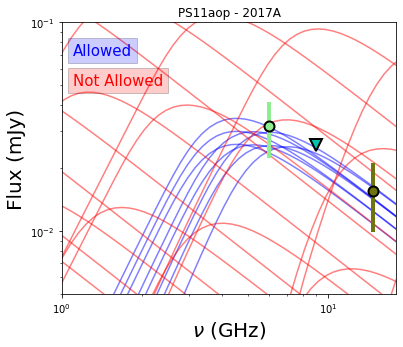

In [6]:
## MAKE A PLOT OF THE SEDS that are allowed: 
D_L = 1070.1 # distance to SN in Mpc
file_in = 'PS11aop_grid_e2+5.csv'
data_plot = ascii.read(file_in)

#########################
#Set up the plot:
#########################
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(6,5))
plt.autoscale()
plt.xscale('log')
plt.yscale('log')


#Allowed
indexa = np.where(data_plot['RuledOut'] == 'False')[0]
data_plota = data_plot[indexa]

Fcalc = data_plota['F_peak'][0:10]
nucalc = data_plota['nu_peak'][0:10]
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)

###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D_L)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    plt.plot(nu_sed,SSA_FFA_sed,'b',zorder=1,alpha=0.5)

 #Not allowed
indexb = np.where(data_plot['RuledOut'] == 'True')[0]
data_plotb = data_plot[indexb]

Fcalc1 = data_plotb['F_peak'][0:1800:44]
nucalc1 = data_plotb['nu_peak'][0:1800:44]
nu_sed1=np.logspace(np.log10(0.1),np.log10(50),num=100)

for i in range(len(Fcalc1)):
    #calculate SSA
    SSA_sed1 = F_nu(t_p,nucalc1[i],Fcalc1[i],nu_sed1)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R1,B1,E1,v1,M1 = SSA_props(t_p,nucalc1[i],Fcalc1[i],D_L)

    #calculate tau_ff
    tauff1 = taufreefree(M1,R1,nu_sed1)
        
    #Correct SED for FFA:
    SSA_FFA_sed1 = SSA_sed1*np.exp(-tauff1)
    
    #Plot it:
    plt.plot(nu_sed1,SSA_FFA_sed1,'r',zorder=1,alpha=0.5)
    
#Overplot the data:
#plt.plot(3.0,0.405, 'kv', markersize=10)
plt.errorbar(6.0,0.0318,0.0095,fmt ='o',color='lightgreen',markersize=10,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#'ro', markersize=10)
plt.plot(9.02,0.0258, 'v', markersize=12,color='xkcd:turquoise',linewidth=4,markeredgecolor='k',markeredgewidth=2)
plt.errorbar(14.74,0.0155, 0.0056,fmt='o',color='xkcd:olive',markersize=10,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#, markersize=10)
plt.text(1.1,0.07,'Allowed',color = 'b',fontsize=15,bbox={'facecolor': 'b', 'alpha': 0.2, 'pad': 5})
plt.text(1.1,0.05,'Not Allowed',color='r',fontsize=15,bbox={'facecolor': 'r', 'alpha': 0.2, 'pad': 5})
plt.xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
plt.ylabel('Flux (mJy)', fontsize=20) 
plt.savefig('multiPS11aop.pdf')
plt.title('PS11aop - 2017A')   
plt.ylim(5e-3,1e-1)
plt.xlim(1,18)
plt.show()

